# **CV PROJECT: Bone Tumor X-Ray Detection & Classification**

---
## **MODEL BUILDING:**
### **DENSENET121 - CheXpert - Bounding Box Focused**
Author : Karthik Paranthaman

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install torchxrayvision

In [ ]:
# System and OS utilities
import os
import sys
import json
import random
from copy import deepcopy

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Image handling
from PIL import Image, ImageOps

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchxrayvision as xrv

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


### Set Up Paths & Load Metadata

In [ ]:
# For running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/CV_Project/BTXRD"
else:
    try:

        SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:

        SCRIPT_DIR = os.getcwd()


    BASE_DIR = os.path.abspath(os.path.join(SCRIPT_DIR, ".."))

    if not os.path.exists(BASE_DIR):
        raise FileNotFoundError(f"BASE_DIR not found: {BASE_DIR}")

# Other related directories
METADATA_DIR = os.path.join(BASE_DIR, "metadata")
ANNOTATIONS_DIR = os.path.join(BASE_DIR, "Annotations")
MODELS_DIR = os.path.join(BASE_DIR, "models")
HISTORY_DIR = os.path.join(BASE_DIR, "history")

#
if not IN_COLAB:
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

# Metadata full paths:
main_path = os.path.join(METADATA_DIR, "main_dataframe.xlsx")
annot_path = os.path.join(METADATA_DIR, "annotated_dataframe.xlsx")

# Check file existence:
assert os.path.exists(main_path), f"Missing file: {main_path}"
assert os.path.exists(annot_path), f"Missing file: {annot_path}"

# Load data
main_df = pd.read_excel(main_path)
annotated_df = pd.read_excel(annot_path)

# Image path: I running in Colabb:
if IN_COLAB:
    for df in [main_df, annotated_df]:
        df["image_path"] = df["image_path"].str.replace(
            "/content/drive/MyDrive/CV_Project/BTXRD", BASE_DIR
        )

print("Data loaded successfully.")
print(f"BASE_DIR is set to: {BASE_DIR}")
print(f"Metadata directory: {METADATA_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.
BASE_DIR is set to: /content/drive/MyDrive/CV_Project/BTXRD
Metadata directory: /content/drive/MyDrive/CV_Project/BTXRD/metadata


### **Evaluation Wrapper Function:**

In [ ]:
def evaluate_model(model, dataloader, device, class_names, dataset_name="Dataset"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {dataset_name}:\n")
    labels_range = list(range(len(class_names)))  # [0, 1, 2]
    print(classification_report(
        y_true, y_pred,
        labels=labels_range,
        target_names=class_names,
        zero_division=0  
    ))

    cm = confusion_matrix(y_true, y_pred, labels=labels_range)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


def plot_training_curves(history_df, title_prefix=""):
      epochs = range(1, len(history_df) + 1)
      fig, axes = plt.subplots(2, 1, figsize=(10, 10))

      # Accuracy
      axes[0].plot(epochs, history_df['train_acc'], label='Train Accuracy', color='tab:blue')
      axes[0].plot(epochs, history_df['val_acc'], label='Validation Accuracy', color='tab:orange')
      axes[0].set_title(f'{title_prefix}Accuracy vs Epochs')
      axes[0].set_xlabel('Epoch')
      axes[0].set_ylabel('Accuracy')
      axes[0].legend()
      axes[0].grid(True)

      # Loss
      axes[1].plot(epochs, history_df['train_loss'], label='Train Loss', color='tab:red')
      axes[1].plot(epochs, history_df['val_loss'], label='Validation Loss', color='tab:green')
      axes[1].set_title(f'{title_prefix}Loss vs Epochs')
      axes[1].set_xlabel('Epoch')
      axes[1].set_ylabel('Loss')
      axes[1].legend()
      axes[1].grid(True)

      plt.tight_layout()
      plt.show()    

Fcoused on lower limb and pelvis body parts only.

Shape of the focused dataframe:(2622, 42)

Class distribution:
-------------------
label
Normal       1207
Benign       1153
Malignant     262
Name: count, dtype: int64



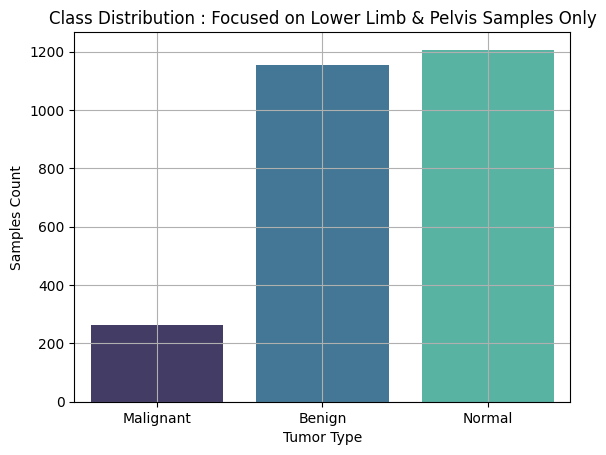

In [ ]:
model_df = main_df[(main_df['lower limb']==1) | (main_df['pelvis']==1)]

print("Fcoused on lower limb and pelvis body parts only.\n")
print(f"Shape of the focused dataframe:{model_df.shape}\n")

print("Class distribution:")
print("-------------------")

print(f"{model_df['label'].value_counts()}\n")

sns.countplot(data = model_df,x='label',hue='label',palette='mako')
plt.title("Class Distribution : Focused on Lower Limb & Pelvis Samples Only")
plt.xlabel("Tumor Type")
plt.ylabel("Samples Count")
plt.grid()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train_df,temp_df = train_test_split(model_df,
                                    stratify=model_df['label'],
                                    test_size = 0.35,
                                    random_state=369)

val_df,test_df = train_test_split(temp_df,
                                  stratify=temp_df['label'],
                                  test_size=20/35,
                                  random_state=369)

# Train, Validation & Test Split size:
print(f"Train Dataset Size : {train_df.shape}")
print(f"Validation Dataset Size : {val_df.shape}")
print(f"Test Dataset Size : {test_df.shape}")
print('\n',train_df['label'].value_counts())

Train Dataset Size : (1704, 42)
Validation Dataset Size : (393, 42)
Test Dataset Size : (525, 42)

 label
Normal       785
Benign       749
Malignant    170
Name: count, dtype: int64


### SECTION 3: Utility - Extract Bounding Box from JSON

In [ ]:
def extract_first_rectangle(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    for shape in data['shapes']:
        if shape['shape_type'] == 'rectangle':
            (x1, y1), (x2, y2) = shape['points']
            xmin = int(min(x1, x2))
            xmax = int(max(x1, x2))
            ymin = int(min(y1, y2))
            ymax = int(max(y1, y2))
            return (xmin, ymin, xmax, ymax)

    return None

#### SECTION 4: Custom Dataset with BB Cropping

In [ ]:
class XRayBBDataset(Dataset):
    def __init__(self, dataframe, transform=None, annotations_dir=None, target_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.annotations_dir = annotations_dir
        self.class_to_idx = {'Normal': 0, 'Benign': 1, 'Malignant': 2}
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        label_idx = self.class_to_idx[label]

        img = Image.open(img_path).convert("RGB")

        # Croping using BB for Benign & Malignant
        if label in ['Benign', 'Malignant']:
            json_name = os.path.splitext(os.path.basename(img_path))[0] + '.json'
            json_path = os.path.join(self.annotations_dir, json_name)

            if os.path.exists(json_path):
                bbox = extract_first_rectangle(json_path)
                if bbox:
                    img = img.crop(bbox)

        img = img.convert('L') 

        # Zeop Padding:
        img = self._pad_to_square(img)

        if self.transform:
            img = self.transform(img)

        return img, label_idx

    def _pad_to_square(self, img):
        w, h = img.size
        if w == h:
            return img
        max_side = max(w, h)
        padding = (
            (max_side - w) // 2,  # left
            (max_side - h) // 2,  # top
            (max_side - w + 1) // 2,  # right
            (max_side - h + 1) // 2,  # bottom
        )
        return ImageOps.expand(img, padding, fill=0)  

#### SECTION 5: Define Transforms, Dataset, and DataLoaders

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# 1-channel normalization for grayscale images
mean = [0.5]
std = [0.5]

# Grayscale transforms 
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Force grayscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Data splits
# train_df, temp_df = train_test_split(annotated_df, test_size=0.3, stratify=annotated_df['label'], random_state=369)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=369)

# Datasets
train_dataset = XRayBBDataset(train_df, transform=train_transform, annotations_dir=ANNOTATIONS_DIR)
val_dataset = XRayBBDataset(val_df, transform=val_transform, annotations_dir=ANNOTATIONS_DIR)
test_dataset = XRayBBDataset(test_df, transform=val_transform, annotations_dir=ANNOTATIONS_DIR)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

num_classes = len(train_dataset.class_to_idx)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_df['label'].value_counts()

,count
label,
Normal,785
Benign,749
Malignant,170


**RANDOM PROCESSED INPUT SAMPLES:**

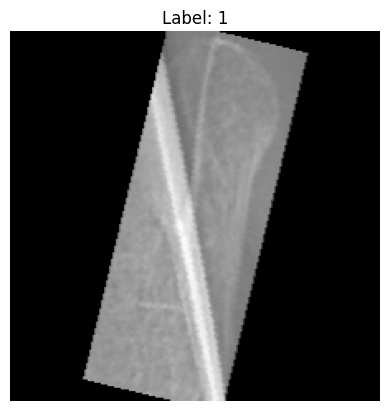

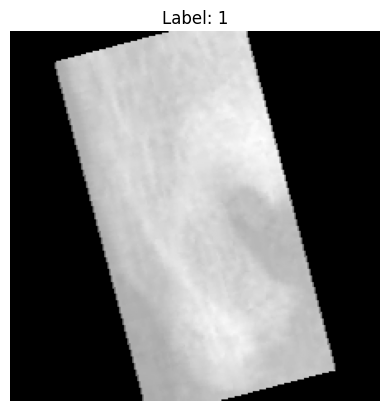

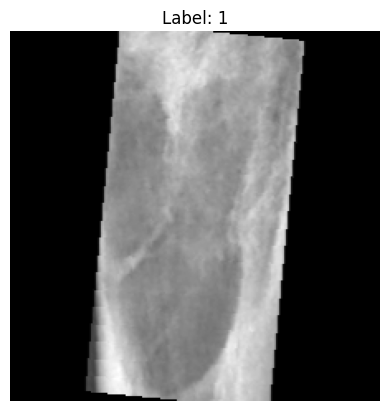

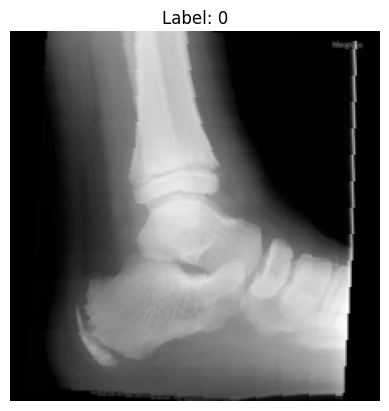

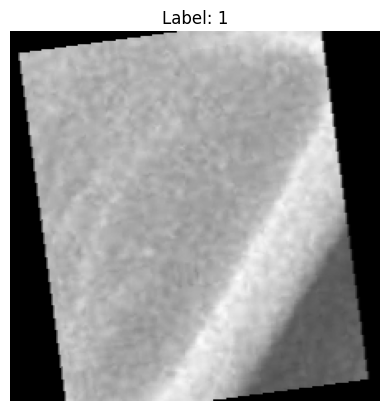

In [ ]:
for _ in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


#### SECTION 6: Define Dense_BB Model (Based on DenseNet121 + Custom Head)

In [ ]:
class DenseNet121_BB(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNet121_BB, self).__init__()

        # DenseNet121 backbone:
        self.backbone = xrv.models.DenseNet(weights="densenet121-res224-chex")

        
        for param in self.backbone.parameters():
            param.requires_grad = False

       
        self.features = self.backbone.features

        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Instantiate Model & Move to GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121_BB(num_classes=3).to(device)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


Class Weights:

In [ ]:
label_map = {'Normal': 0, 'Benign': 1, 'Malignant': 2}
train_df['label_encoded'] = train_df['label'].map(label_map)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_encoded']),
    y=train_df['label_encoded']
)

# class_weights = torch.tensor(class_weights_array, dtype=torch.float).to(device)

# Manual tuning:
class_weights = torch.tensor([0.98, 1.0, 1.8], dtype=torch.float).to(device)

print("Class weights:", class_weights)

Class weights: tensor([0.9800, 1.0000, 1.8000])


### SECTION 7: Training Phase 1 (Frozen Backbone)
7.1. Frozen Base (Redundant Safety Step)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False


7.2. Define Loss Function, Optimizer & Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

optimizer = optim.Adam(model.classifier.parameters(), lr=3e-3, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

7.3. Define Training Function (with Early Stopping & Logging)

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    early_stop_patience=5,
    save_path="best_dense_bb_phase1.pth",
    log_path="train_log_dense_bb_phase1.csv"
):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    best_model_wts = deepcopy(model.state_dict())

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- TRAIN ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- VALIDATION ---
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # --- Logging ---
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        for param_group in optimizer.param_groups:
            print(f"LR: {param_group['lr']:.6f}")

        # --- Early Stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = deepcopy(model.state_dict())
            no_improve_epochs = 0
            torch.save(model.state_dict(), save_path)
            print("New best model saved.")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epoch(s).")
            if no_improve_epochs >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_model_wts)

    # Save training log
    log_df = pd.DataFrame({
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    })
    log_df.to_csv(log_path, index=False)
    print("Training log saved.")

    return model, log_df

7.4 Launch Phase 1 Training

In [ ]:
model, log_df = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=25,
    early_stop_patience=5,
    save_path=os.path.join(MODELS_DIR, "dense_bb_phase1.pth"),
    log_path=os.path.join(HISTORY_DIR, "log_dense_bb_phase1.csv")
)


Epoch 1/25


Validation: 100%|██████████| 13/13 [02:48<00:00, 12.96s/it]


Train Loss: 0.7615, Acc: 0.7782 | Val Loss: 4.0647, Acc: 0.4402
LR: 0.003000
New best model saved.

Epoch 2/25


Validation: 100%|██████████| 13/13 [02:25<00:00, 11.21s/it]


Train Loss: 0.6707, Acc: 0.8234 | Val Loss: 2.1173, Acc: 0.4402
LR: 0.003000
New best model saved.

Epoch 3/25


Validation: 100%|██████████| 13/13 [02:33<00:00, 11.82s/it]


Train Loss: 0.6639, Acc: 0.8363 | Val Loss: 0.6452, Acc: 0.8346
LR: 0.003000
New best model saved.

Epoch 4/25


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.03s/it]


Train Loss: 0.6404, Acc: 0.8498 | Val Loss: 0.6450, Acc: 0.8397
LR: 0.003000
New best model saved.

Epoch 5/25


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


Train Loss: 0.6376, Acc: 0.8633 | Val Loss: 0.6389, Acc: 0.8295
LR: 0.003000
New best model saved.

Epoch 6/25


Validation: 100%|██████████| 13/13 [02:28<00:00, 11.45s/it]


Train Loss: 0.6560, Acc: 0.8380 | Val Loss: 0.6389, Acc: 0.8270
LR: 0.003000
No improvement for 1 epoch(s).

Epoch 7/25


Validation: 100%|██████████| 13/13 [02:25<00:00, 11.22s/it]


Train Loss: 0.6306, Acc: 0.8568 | Val Loss: 0.6190, Acc: 0.8473
LR: 0.003000
New best model saved.

Epoch 8/25


Validation: 100%|██████████| 13/13 [02:21<00:00, 10.88s/it]


Train Loss: 0.6300, Acc: 0.8545 | Val Loss: 0.6080, Acc: 0.8524
LR: 0.003000
New best model saved.

Epoch 9/25


Validation: 100%|██████████| 13/13 [02:26<00:00, 11.23s/it]


Train Loss: 0.6132, Acc: 0.8627 | Val Loss: 0.6213, Acc: 0.8372
LR: 0.003000
No improvement for 1 epoch(s).

Epoch 10/25


Validation: 100%|██████████| 13/13 [02:22<00:00, 10.95s/it]


Train Loss: 0.6142, Acc: 0.8627 | Val Loss: 0.6253, Acc: 0.8270
LR: 0.003000
No improvement for 2 epoch(s).

Epoch 11/25


Validation: 100%|██████████| 13/13 [02:24<00:00, 11.13s/it]


Train Loss: 0.6088, Acc: 0.8715 | Val Loss: 0.6110, Acc: 0.8346
LR: 0.003000
No improvement for 3 epoch(s).

Epoch 12/25


Validation: 100%|██████████| 13/13 [02:24<00:00, 11.15s/it]


Train Loss: 0.6136, Acc: 0.8509 | Val Loss: 0.6133, Acc: 0.8575
LR: 0.000900
No improvement for 4 epoch(s).

Epoch 13/25


Validation: 100%|██████████| 13/13 [02:22<00:00, 10.99s/it]


Train Loss: 0.6253, Acc: 0.8562 | Val Loss: 0.6055, Acc: 0.8448
LR: 0.000900
New best model saved.

Epoch 14/25


Validation: 100%|██████████| 13/13 [02:28<00:00, 11.41s/it]


Train Loss: 0.6092, Acc: 0.8685 | Val Loss: 0.6072, Acc: 0.8372
LR: 0.000900
No improvement for 1 epoch(s).

Epoch 15/25


Validation: 100%|██████████| 13/13 [02:26<00:00, 11.26s/it]


Train Loss: 0.5879, Acc: 0.8750 | Val Loss: 0.5922, Acc: 0.8626
LR: 0.000900
New best model saved.

Epoch 16/25


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.04s/it]


Train Loss: 0.5772, Acc: 0.8873 | Val Loss: 0.5933, Acc: 0.8295
LR: 0.000900
No improvement for 1 epoch(s).

Epoch 17/25


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.06s/it]


Train Loss: 0.5766, Acc: 0.8867 | Val Loss: 0.6020, Acc: 0.8346
LR: 0.000900
No improvement for 2 epoch(s).

Epoch 18/25


Validation: 100%|██████████| 13/13 [02:22<00:00, 10.98s/it]


Train Loss: 0.5808, Acc: 0.8820 | Val Loss: 0.5927, Acc: 0.8422
LR: 0.000900
No improvement for 3 epoch(s).

Epoch 19/25


Validation: 100%|██████████| 13/13 [02:30<00:00, 11.60s/it]


Train Loss: 0.5948, Acc: 0.8738 | Val Loss: 0.5866, Acc: 0.8702
LR: 0.000900
New best model saved.

Epoch 20/25


Validation: 100%|██████████| 13/13 [02:26<00:00, 11.24s/it]


Train Loss: 0.5752, Acc: 0.8973 | Val Loss: 0.5945, Acc: 0.8321
LR: 0.000900
No improvement for 1 epoch(s).

Epoch 21/25


Validation: 100%|██████████| 13/13 [02:25<00:00, 11.16s/it]


Train Loss: 0.5819, Acc: 0.8862 | Val Loss: 0.5870, Acc: 0.8499
LR: 0.000900
No improvement for 2 epoch(s).

Epoch 22/25


Validation: 100%|██████████| 13/13 [02:33<00:00, 11.79s/it]


Train Loss: 0.5872, Acc: 0.8803 | Val Loss: 0.5789, Acc: 0.8499
LR: 0.000900
New best model saved.

Epoch 23/25


Validation: 100%|██████████| 13/13 [02:21<00:00, 10.92s/it]


Train Loss: 0.5826, Acc: 0.8832 | Val Loss: 0.5922, Acc: 0.8473
LR: 0.000900
No improvement for 1 epoch(s).

Epoch 24/25


Validation: 100%|██████████| 13/13 [02:32<00:00, 11.74s/it]


Train Loss: 0.5772, Acc: 0.8791 | Val Loss: 0.5886, Acc: 0.8906
LR: 0.000900
No improvement for 2 epoch(s).

Epoch 25/25


Validation: 100%|██████████| 13/13 [02:32<00:00, 11.77s/it]


Train Loss: 0.5793, Acc: 0.8815 | Val Loss: 0.5781, Acc: 0.8677
LR: 0.000900
New best model saved.
Training log saved.


Evaluating Train Set: 100%|██████████| 54/54 [10:13<00:00, 11.37s/it]



Classification Report for Train Set:

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       785
      Benign       0.89      0.93      0.91       749
   Malignant       0.60      0.48      0.53       170

    accuracy                           0.91      1704
   macro avg       0.82      0.80      0.81      1704
weighted avg       0.90      0.91      0.91      1704



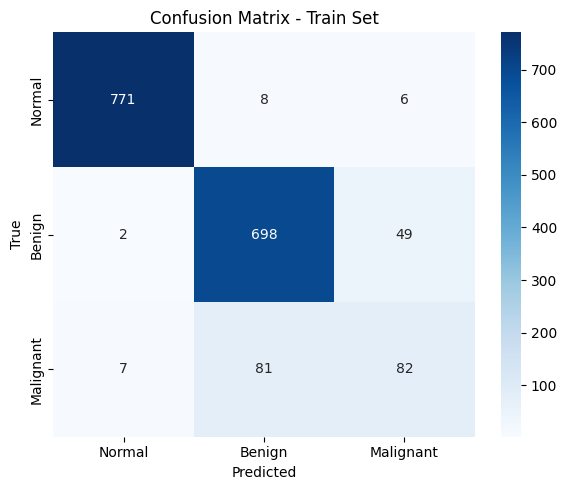

Evaluating Validation Set: 100%|██████████| 13/13 [02:20<00:00, 10.82s/it]



Classification Report for Validation Set:

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       181
      Benign       0.87      0.84      0.86       173
   Malignant       0.44      0.49      0.46        39

    accuracy                           0.87       393
   macro avg       0.76      0.77      0.76       393
weighted avg       0.87      0.87      0.87       393



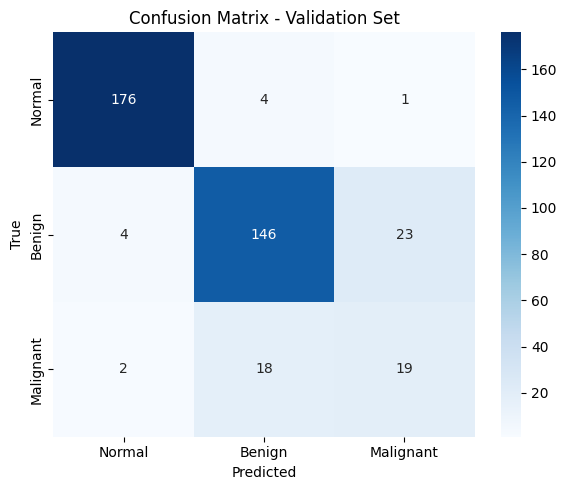

Evaluating Test Set: 100%|██████████| 17/17 [03:03<00:00, 10.81s/it]



Classification Report for Test Set:

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97       241
      Benign       0.85      0.90      0.87       231
   Malignant       0.46      0.43      0.45        53

    accuracy                           0.88       525
   macro avg       0.77      0.76      0.76       525
weighted avg       0.88      0.88      0.88       525



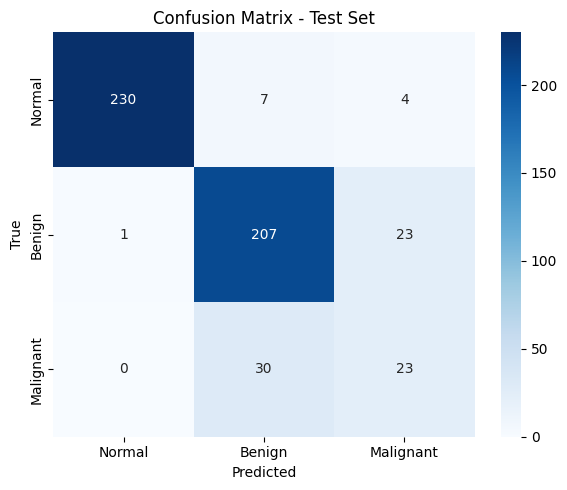

In [ ]:
class_names = ['Normal', 'Benign', 'Malignant']
evaluate_model(model, train_loader, device, class_names, dataset_name="Train Set")
evaluate_model(model, val_loader, device, class_names, dataset_name="Validation Set")
evaluate_model(model, test_loader, device, class_names, dataset_name="Test Set")

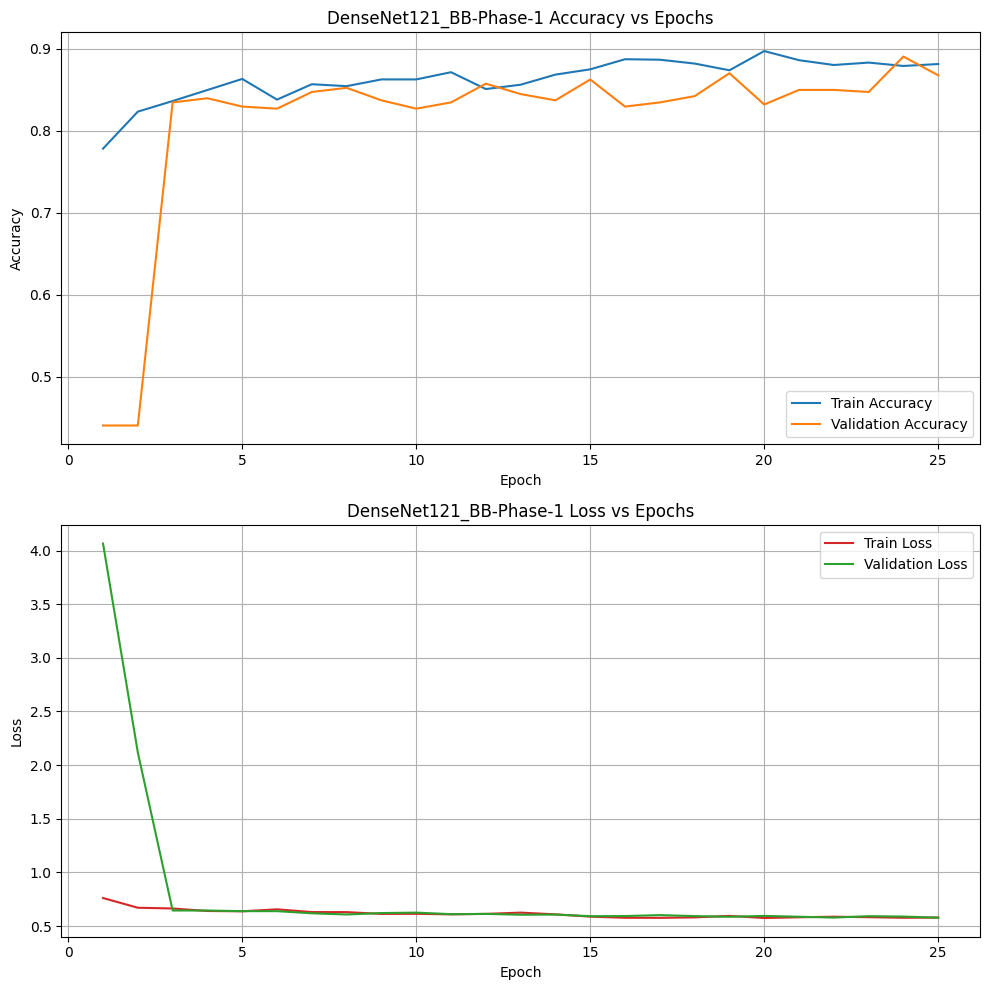

In [ ]:
plot_training_curves(log_df, title_prefix="DenseNet121_BB-Phase-1 ")


## **Phase-2**

Phase-2: Training function (with Gradient Clipping)

In [ ]:
def ph2_train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=15,
    early_stop_patience=5,
    save_path="best_dense_bb_phase2.pth",
    log_path="train_log_dense_bb_phase2.csv",
    grad_clip=1.0
):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    best_model_wts = deepcopy(model.state_dict())

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- TRAIN ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(params_to_train, max_norm=grad_clip)

            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- VALIDATION ---
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # --- Logging ---
        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        for param_group in optimizer.param_groups:
            print(f"LR: {param_group['lr']:.6f}")

        # --- Early Stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = deepcopy(model.state_dict())
            no_improve_epochs = 0
            torch.save(model.state_dict(), save_path)
            print("New best model saved.")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epoch(s).")
            if no_improve_epochs >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_model_wts)

    # Save training log
    log_df = pd.DataFrame({
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs
    })
    log_df.to_csv(log_path, index=False)
    print("Training log saved.")

    return model, log_df

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cpu":
    torch.set_num_threads(torch.get_num_threads())  # Max available threads

# Load Phase-1 best weights
# ------------------------------
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, "dense_bb_phase1.pth"), map_location=device))
model.to(device)


# Freeze all layers except Dense Block 4 and Classifier
# ------------------------------
for param in model.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

params_to_train = list(model.classifier.parameters()) + list(model.features.denseblock4.parameters())


# STEP 3: Define optimizer & scheduler
# ------------------------------
optimizer = AdamW(params_to_train, lr=3e-5, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

# Loss function
criterion = nn.CrossEntropyLoss()

Using device: cpu


In [ ]:
# PHASE-2 : Fine-tuning training
model, log_df = ph2_train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=15,
    early_stop_patience=5,
    save_path=os.path.join(MODELS_DIR, "dense_bb_phase2.pth"),
    log_path=os.path.join(HISTORY_DIR, "log_dense_bb_phase2.csv"),
    grad_clip=1.0
)


Epoch 1/15


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.08s/it]


Train Loss: 0.3229, Acc: 0.8914 | Val Loss: 0.3190, Acc: 0.8677
LR: 0.000030
New best model saved.

Epoch 2/15


Validation: 100%|██████████| 13/13 [02:29<00:00, 11.49s/it]


Train Loss: 0.3097, Acc: 0.8944 | Val Loss: 0.3029, Acc: 0.8830
LR: 0.000030
New best model saved.

Epoch 3/15


Validation: 100%|██████████| 13/13 [02:22<00:00, 11.00s/it]


Train Loss: 0.3004, Acc: 0.8979 | Val Loss: 0.2982, Acc: 0.8906
LR: 0.000030
New best model saved.

Epoch 4/15


Validation: 100%|██████████| 13/13 [02:29<00:00, 11.53s/it]


Train Loss: 0.2861, Acc: 0.8967 | Val Loss: 0.2933, Acc: 0.8855
LR: 0.000030
New best model saved.

Epoch 5/15


Validation: 100%|██████████| 13/13 [02:18<00:00, 10.62s/it]


Train Loss: 0.2876, Acc: 0.8920 | Val Loss: 0.2878, Acc: 0.8880
LR: 0.000030
New best model saved.

Epoch 6/15


Validation: 100%|██████████| 13/13 [02:20<00:00, 10.78s/it]


Train Loss: 0.2830, Acc: 0.8891 | Val Loss: 0.2878, Acc: 0.8880
LR: 0.000030
New best model saved.

Epoch 7/15


Validation: 100%|██████████| 13/13 [02:21<00:00, 10.92s/it]


Train Loss: 0.2685, Acc: 0.9067 | Val Loss: 0.2774, Acc: 0.8906
LR: 0.000030
New best model saved.

Epoch 8/15


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.04s/it]


Train Loss: 0.2768, Acc: 0.9026 | Val Loss: 0.2811, Acc: 0.8931
LR: 0.000030
No improvement for 1 epoch(s).

Epoch 9/15


Validation: 100%|██████████| 13/13 [02:31<00:00, 11.66s/it]


Train Loss: 0.2560, Acc: 0.9049 | Val Loss: 0.2761, Acc: 0.8957
LR: 0.000030
New best model saved.

Epoch 10/15


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.01s/it]


Train Loss: 0.2570, Acc: 0.9020 | Val Loss: 0.2750, Acc: 0.8931
LR: 0.000030
New best model saved.

Epoch 11/15


Validation: 100%|██████████| 13/13 [02:23<00:00, 11.07s/it]


Train Loss: 0.2674, Acc: 0.8920 | Val Loss: 0.2707, Acc: 0.9008
LR: 0.000030
New best model saved.

Epoch 12/15


Validation: 100%|██████████| 13/13 [02:27<00:00, 11.34s/it]


Train Loss: 0.2622, Acc: 0.9026 | Val Loss: 0.2782, Acc: 0.8957
LR: 0.000030
No improvement for 1 epoch(s).

Epoch 13/15


Validation: 100%|██████████| 13/13 [02:21<00:00, 10.89s/it]


Train Loss: 0.2586, Acc: 0.8996 | Val Loss: 0.2714, Acc: 0.8982
LR: 0.000030
No improvement for 2 epoch(s).

Epoch 14/15


Validation: 100%|██████████| 13/13 [02:29<00:00, 11.47s/it]


Train Loss: 0.2518, Acc: 0.9032 | Val Loss: 0.2689, Acc: 0.8957
LR: 0.000030
New best model saved.

Epoch 15/15


Validation: 100%|██████████| 13/13 [02:19<00:00, 10.74s/it]


Train Loss: 0.2590, Acc: 0.9008 | Val Loss: 0.2717, Acc: 0.8982
LR: 0.000030
No improvement for 1 epoch(s).
Training log saved.


Evaluating Train Set: 100%|██████████| 54/54 [10:44<00:00, 11.93s/it]



Classification Report for Train Set:

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       785
      Benign       0.88      0.96      0.92       749
   Malignant       0.68      0.39      0.50       170

    accuracy                           0.92      1704
   macro avg       0.85      0.78      0.80      1704
weighted avg       0.91      0.92      0.91      1704



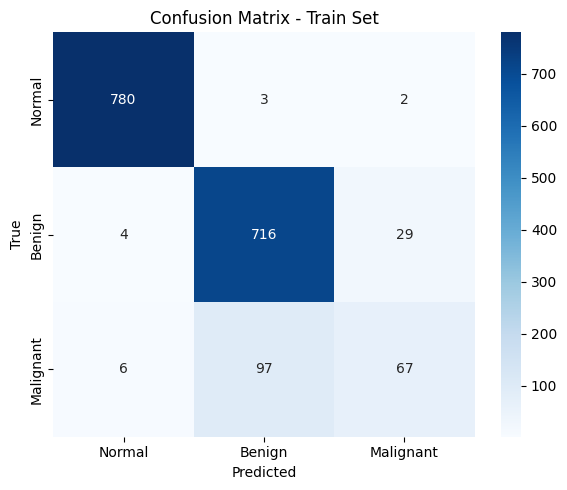

Evaluating Validation Set: 100%|██████████| 13/13 [02:30<00:00, 11.60s/it]



Classification Report for Validation Set:

              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       181
      Benign       0.87      0.92      0.90       173
   Malignant       0.56      0.36      0.44        39

    accuracy                           0.90       393
   macro avg       0.80      0.76      0.77       393
weighted avg       0.88      0.90      0.89       393



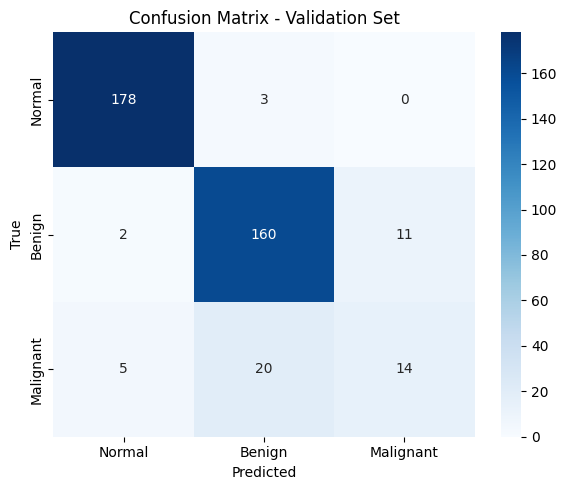

Evaluating Test Set: 100%|██████████| 17/17 [03:16<00:00, 11.59s/it]



Classification Report for Test Set:

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       241
      Benign       0.85      0.95      0.90       231
   Malignant       0.57      0.30      0.40        53

    accuracy                           0.90       525
   macro avg       0.80      0.74      0.76       525
weighted avg       0.89      0.90      0.89       525



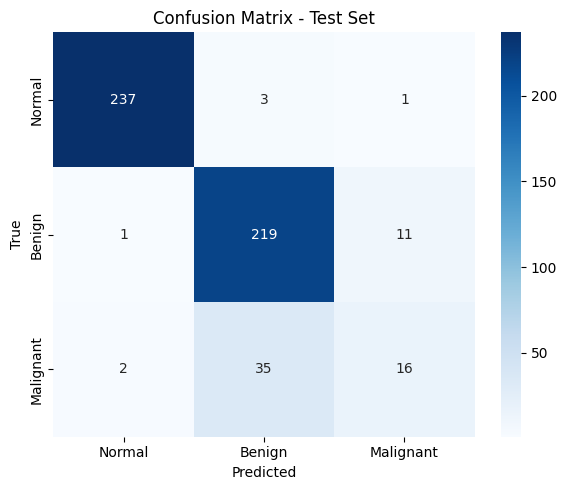

In [ ]:
evaluate_model(model, train_loader, device, class_names, dataset_name="Train Set")
evaluate_model(model, val_loader, device, class_names, dataset_name="Validation Set")
evaluate_model(model, test_loader, device, class_names, dataset_name="Test Set")

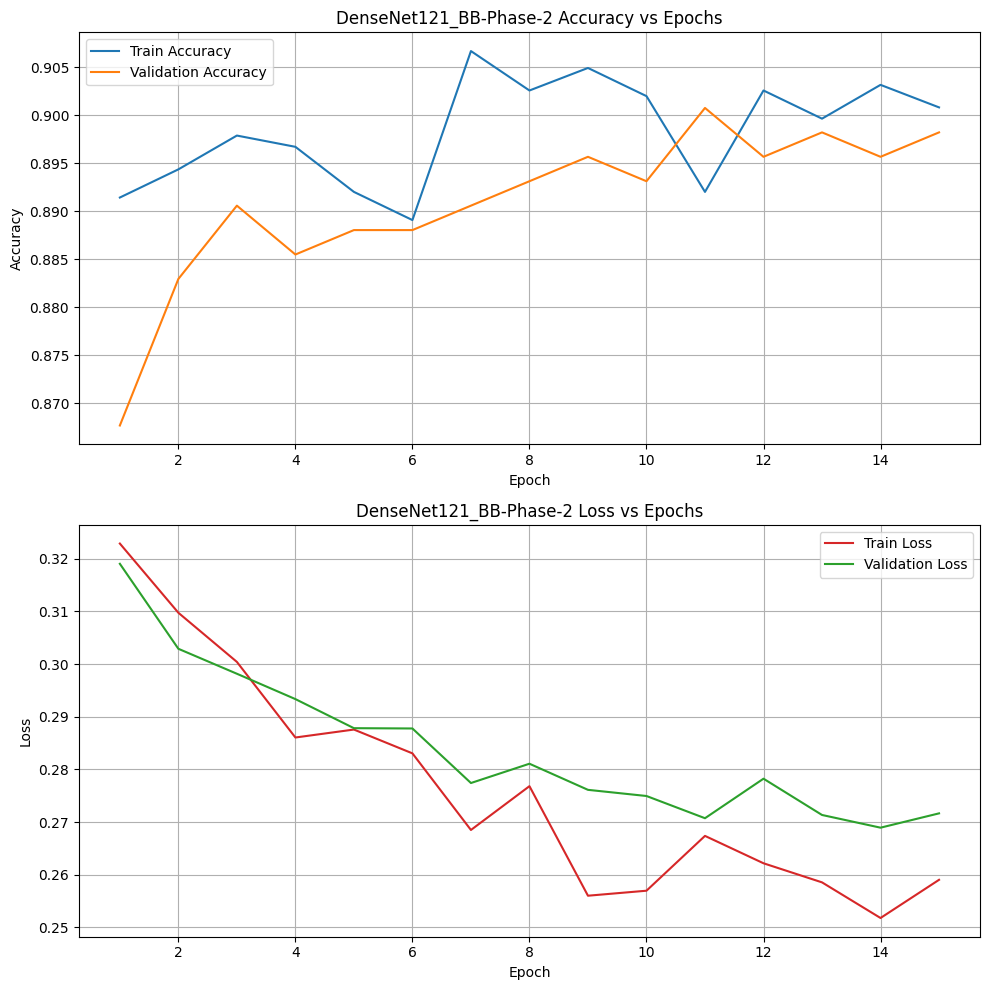

In [ ]:
plot_training_curves(log_df, title_prefix="DenseNet121_BB-Phase-2 ")